In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

In [2]:
import numpy as np
from functools import partial
from scipy.spatial import cKDTree

# ATMO 5331 - Homework 5 & 6 - Fall 2025
## Due **Tuesday** 25 Nov, 2025, 2:00 pm (**start of class**)
## *Worth two assignments*

When doing this homework (150 pts total), remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB: grade 118/150</span>

**1.** Copy in your setup from HW3, so that you have the radar data, radar locations, and analysis grid available. Use only the tangent plane cartesian system part, and you don't need to include the plots. Take the time to clean up your original code so that it's the minimally necessary set of variables and functions. (25 pts)

In [3]:
# copying in the setup from HW3 
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
ds = xr.open_dataset('Ka2140614021408.RAWPXA9.nc', decode_timedelta=True)

print(ds)

# Print the first ten elevation angles.
print(ds.variables['elevation'][0:10])

# Shortcut to variable access
print(ds.elevation[0:10])

print(ds.sweep_mode)
print(ds.sweep_start_ray_index)
print(ds.sweep_end_ray_index)
    
scan_idx = 1

#start/end sweep
sw_start= int(ds.sweep_start_ray_index.values[scan_idx])
sw_end= int(ds.sweep_end_ray_index.values[scan_idx])

#selecting rays for the sweep
ray_slice= slice(sw_start, sw_end+1)

az = ds.azimuth.isel(time= ray_slice).values
el = ds.elevation.isel(time= ray_slice).values
t = ds.time.isel(time= ray_slice).values

nrays= az.size

# 1D array in m
if 'range' in ds:
    rng= ds['range'].values
elif 'distance' in ds:
    rng= ds['distance'].values
else:
    raise KeyError("No 'range' or 'distance' variables found in dataset")
    
ngates= rng.size

# importing TPCS
from coords import TangentPlaneCartesianSystem

# Radar location
radar_lat= ds.latitude.values
radar_lon= ds.longitude.values
radar_alt= ds.altitude.values

tangent= TangentPlaneCartesianSystem(radar_lat, radar_lon, radar_alt)

# choosing a reflectivity data field 
print('\nAvailable data variables:', list(ds.data_vars))
preferred= 'reflectivity'
if preferred in ds: 
    field_name= preferred
else: 
    field_name= list(ds.data_vars)[0]
    print(f"Using Field '{field_name}' as fallback")
    
field= ds[field_name].isel(time= ray_slice).values

# polar to East North Up (m)
def polar_to_enu(az_deg, el_deg, r):
    azr= np.deg2rad(az_deg)
    elr= np.deg2rad(el_deg)
    horiz= r * np.cos(elr)
    x_e= horiz * np.sin(azr)   # east
    y_n= horiz * np.cos(azr)   # north
    z_u= r * np.sin(elr)       # up
    return x_e, y_n, z_u

# building broadcasted gate coordinates for the sweep
az2 = az[:, None]     # (nrays, 1)
el2 = el[:, None]     # (nrays, 1)
rng2 = rng[None, :]   # (1, ngates)

x_e, y_n, z_u = polar_to_enu(az2, el2, rng2)

# defining the grid centered on the radar
Rmax = float(np.nanmax(rng))
dx = 500.0   # meters, change as you like
xvec = np.arange(-Rmax, Rmax + dx, dx)
yvec = np.arange(-Rmax, Rmax + dx, dx)
Xg, Yg = np.meshgrid(xvec, yvec)   # grid in east (Xg) and north (Yg) coords

# flattened (valid) gate locations + KDTree for interpolation
gate_xy = np.column_stack((x_e.ravel(), y_n.ravel()))   # (nrays*ngates, 2)
field_flat = field.ravel()
valid = np.isfinite(field_flat)

gate_xy_valid = gate_xy[valid]
field_valid = field_flat[valid]
tree= cKDTree(gate_xy_valid)

print(f"\nSelected sweep #{scan_idx}: rays {sw_start}..{sw_end} -> nrays={nrays}, ngates={ngates}")
print(f"Field used: '{field_name}' with {gate_xy_valid.shape[0]} valid gates")
print(f"Analysis grid: x from {xvec.min():.0f} to {xvec.max():.0f} m, dx={dx} m")

c:\Users\melmo\anaconda3\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 98MB
Dimensions:                    (time: 2938, range: 1666, sweep: 5)
Coordinates:
  * time                       (time) datetime64[ns] 24kB 2014-06-14T02:14:19...
  * range                      (range) float32 7kB 0.0 15.0 ... 2.498e+04
    azimuth                    (time) float32 12kB ...
    elevation                  (time) float32 12kB ...
Dimensions without coordinates: sweep
Data variables: (12/25)
    total_power                (time, range) float32 20MB ...
    reflectivity               (time, range) float32 20MB ...
    velocity                   (time, range) float32 20MB ...
    spectrum_width             (time, range) float32 20MB ...
    normalized_coherent_power  (time, range) float32 20MB ...
    sweep_number               (sweep) int32 20B ...
    ...                         ...
    longitude                  float64 8B ...
    altitude                   float64 8B ...
    time_coverage_start        |S32 32B ...
    time_coverage_end         

<span class="ecb">Analysis domain doesn't match what you had in HW3. -8</span>

**2.** Configuration of the weighting scheme requires that we know the typical data spacing. Following [TD2000](https://journals.ametsoc.org/view/journals/atot/17/2/1520-0426_2000_017_0105_rdoa_2_0_co_2.xml?tab_body=fulltext-display), define the data spacing as the distance betweent two radar gates at the maximum range. Use the point in your analysis grid that is farthest from the radar, and then find the maximum spacing in meters between radar gates along changes in elevation angle at this range.

Please provide an answer to these two questions:
- What is the maximum distance from the radar in the objective analysis domain? (10 pts)
- What is the maximum spacing between two adjacent data points? (10 pts)

In [4]:
# max distance from radar in analysis domain
grid_dists= np.sqrt(Xg**2+Yg**2)  # each grid cell from radar (m)
flat_idx= np.nanargmax(grid_dists)
imax, jmax= np.unravel_index(flat_idx, grid_dists.shape)
farthest_xy= (Xg[imax, jmax], Yg[imax, jmax])
farthest_distance_m= float(grid_dists[imax, jmax])

# Range index that dist best matches farthest dist
gate_horiz= np.sqrt(x_e**2 + y_n**2)
mean_gate_horiz= np.nanmean(gate_horiz, axis= 0)
j_closest= int(np.argmin(np.abs(mean_gate_horiz - farthest_distance_m)))

# spacing between rays
pts= np.column_stack((x_e[:, j_closest], y_n[:, j_closest]))
dists_adj= np.sqrt(np.sum(np.diff(pts, axis= 0)**2, axis= 1))  # dist between consecutive rays
max_adjacent_spacing_m= float(np.nanmax(dists_adj))

# Printing
print("Farthest Analysis-Grid Point (East, North) [m]:", (farthest_xy[0], farthest_xy[1]))
print("Maximum Distance from Radar in the Analysis Domain [m]:", f"{farthest_distance_m:.1f}")
print("Gate Index Closest to that Distance (range index):", j_closest)
print("Mean Gate Horizontal Distance at that Range [m]:", f"{mean_gate_horiz[j_closest]:.1f}")
print("Maximum Spacing between Adjacent Data Points at that Range [m]:", f"{max_adjacent_spacing_m:.2f}")

Farthest Analysis-Grid Point (East, North) [m]: (25025.0, 25025.0)
Maximum Distance from Radar in the Analysis Domain [m]: 35390.7
Gate Index Closest to that Distance (range index): 1665
Mean Gate Horizontal Distance at that Range [m]: 20632.6
Maximum Spacing between Adjacent Data Points at that Range [m]: 63.23


<span class="ecb">Appears to be calculated correctly, even though wrong analysis domain.</span>

**3.** Below, the function `oban` (for "objective analysis") mimics the call signature of the MetPy `interpolate_to_points` function. Its principal difference is the `weight_func` argument, which takes a function instead of a string describing an interpolation method. 

The `oban` function passes `weight_func` only the distances, so it is necessary to use `partial` to pre-fill the function with any other arguments needed to configure the weight function. The `sample_weights` function below shows how this works.

For fun, I've also included a seasonal illustration of the use of `partial`.

For this question, your jobs are as follows.

**a.**  Specify a cutoff radius. Based on the last homework assignment, what is a good distance to use as a multiple of the data spacing? Make sure to adjust your set of input data points to include the necessary margin beyond the perimeter of the analysis grid. (5 pts)

**b.**  Implement a `barnes` function and then use it with `oban` to calculate an analysis for reflectivity on the target grid.  Note that you will need to complete the `oban` function in a way that will work with any weight function. (5 pts)

**c.**  Calculate a Barnes analysis using MetPy, as in the last assignment, and find the difference (yours - MetPy). They probably won't be the same, even for a sane configuration of parameters; that's ok. (10 pts)

**d.**  Plot the original data, the two analyses, and the difference. (20 pts)


In [5]:
# a. specify a cutoff radius
print('a) Specify a cutoff radius and adjust input data points.')

from functools import partial

# TD2000: cutoff radius chosen is a few times the data spacing (3x)
data_spacing= max_adjacent_spacing_m
cutoff_factor= 3.0
search_radius= cutoff_factor*data_spacing

print(f"Using Data Spacing= {data_spacing:.2f} m; Cutoff Radius= {search_radius:.2f} m (factor {cutoff_factor})")

# Expanding to include beyond the grid edges
margin= search_radius

# Analysis grid using Xg and Yg
xmin, xmax= Xg.min() - margin, Xg.max() + margin
ymin, ymax= Yg.min() - margin, Yg.max() + margin

# Filtering the gate points 
in_box= np.logical_and.reduce([gate_xy_valid[:, 0]>= xmin, gate_xy_valid[:, 0]<= xmax,
                               gate_xy_valid[:, 1]>= ymin, gate_xy_valid[:, 1]<= ymax,])
points= gate_xy_valid[in_box]   # shape (N_keep, 2)
values= field_valid[in_box]     # shape (N_keep,)

print(f"Kept {points.shape[0]} of {gate_xy_valid.shape[0]} gates within extended domain for interpolation.")

a) Specify a cutoff radius and adjust input data points.
Using Data Spacing= 63.23 m; Cutoff Radius= 189.68 m (factor 3.0)
Kept 861801 of 861801 gates within extended domain for interpolation.


In [6]:
def thanksgiving(holiday_question, pie=False):
    print(holiday_question, "pie?", pie)

In [7]:
thanksgiving("On this day will I eat", pie=True)

On this day will I eat pie? True


In [8]:
bad_thanksgiving = partial(thanksgiving, "On this day will I eat")

In [9]:
bad_thanksgiving("No, because I forgot to make pie.")

On this day will I eat pie? No, because I forgot to make pie.


In [10]:
#b. Barnes function
print('b) Implement a Barnes function and calculate reflectivity')

def barnes_weight(r, gamma): 
    """
    r: array of distances
    gamma: smoothing length-scale
    """
    barnes_funct= np.exp(-(r**2)/(gamma**2))  # avoiding overflow when r is large
    return barnes_funct
      
def oban(points, values, xi, weight_func, search_radius):
    """
    points: N,2 data point locations
    values: N data values
    xi: M,2 analysis locations
    weight_func is a function that accepts a single argument r that is the
        distance between the analysis location and all points within search_radius
        of the analysis location.
    """
    
    # Find all points in the vicinity of each analysis location in xi
    tree = cKDTree(points)
    query = tree.query_ball_point(xi, search_radius)
    neighbors_list= tree.query_ball_point(xi, search_radius)
    analysis = np.zeros(xi.shape[0])
    
    # This is linear (times the typical neighborhood size) in the number of analysis points
    for i, neigh_idx in enumerate(neighbors_list):
        if len(neigh_idx) == 0: 
            continue 
        locs= points[neigh_idx]
        vals= values[neigh_idx]
        r= np.sqrt(np.sum((locs-xi[i])**2, axis= 1))
        w= weight_func(r)
        wsum= np.nansum(w)
        if wsum== 0 or np.all(np.isnan(w)):
            analysis[i]= np.nan
        else: 
            analysis[i] = np.nansum(w*vals)/wsum
    return analysis

gamma= data_spacing
barnes_func= partial(barnes_weight, gamma= gamma)

# flatten grid points
xi= np.column_stack((Xg.ravel(), Yg.ravel()))

# Running oban with barnes weights
analysis_barnes_flat= oban(points, values, xi, barnes_func, search_radius)
analysis_barnes= analysis_barnes_flat.reshape(Xg.shape)

def sample_weights(r, value=None):
    return np.zeros_like(r) + value

my_weight_func = partial(sample_weights, value=3.0)
my_test_ranges = np.arange(10.0)
my_test_weights = my_weight_func(my_test_ranges) # oban will call my_weight_func like so
print(my_test_weights) 

b) Implement a Barnes function and calculate reflectivity
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


<span class="ecb">Cutoff is good. kappa (related to your gamma) should include kappa_star and Ln -3.</span>

c) Calculate a Barnes Analysis using MetPy and find the difference
Recomputing analysis_oban with oban (full observations). This may take a moment...
Recomputed analysis_oban shape: (101, 101)

Attempting MetPy Barnes on full dataset (may raise MemoryError)...
MetPy Barnes on full dataset raised MemoryError (common). Falling back to sampled obs approach.

Running MetPy Barnes on a random sample of observations (Nmax=2000).
MetPy Barnes Succeeded on Sampled Obs: metpy_arr.shape: (10, 48) finite: 34 / 480

d) Plots


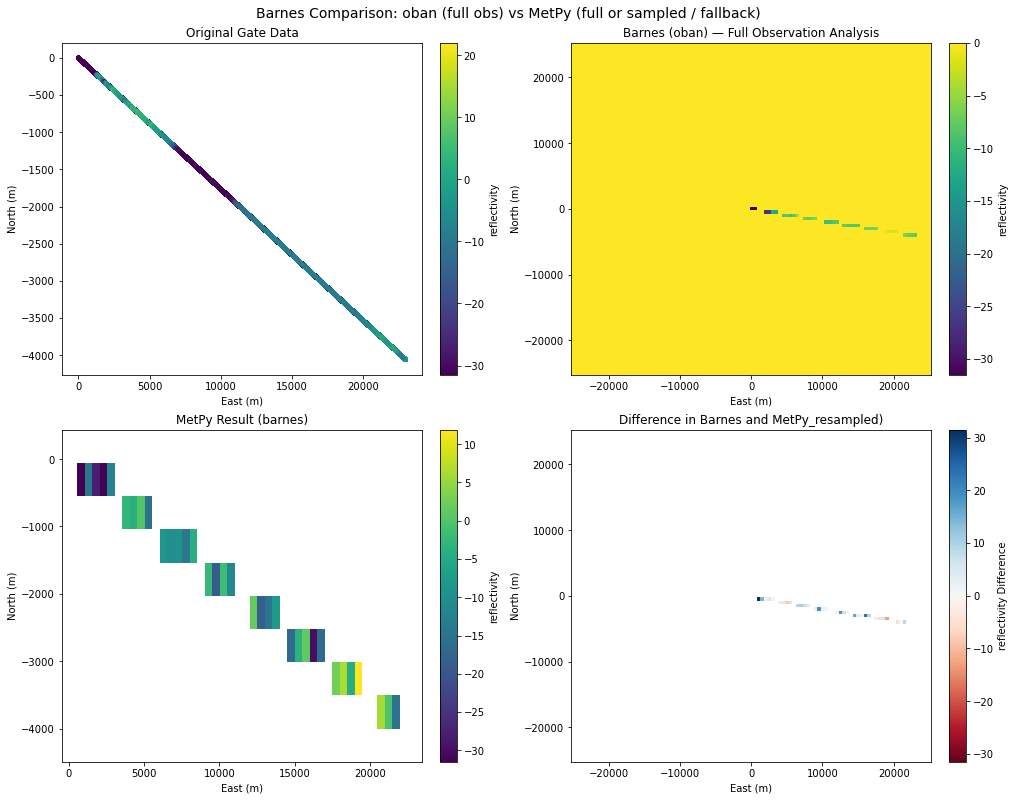


Diagnostics:
oban grid shape: (101, 101)  finite: 10201 / 10201
metpy grid shape: (10, 48)  finite: 34 / 480
resampled metpy->oban finite: 33 / 10201
MetPy method used: barnes (full or sampled)


In [11]:
# c. 
print('c) Calculate a Barnes Analysis using MetPy and find the difference')

from functools import partial
from metpy.interpolate import interpolate_to_grid
import traceback

# Making sure required variables there
required = ['points', 'values', 'Xg', 'Yg', 'gamma', 'data_spacing', 'search_radius', 'dx']
missing = [v for v in required if v not in globals()]
if missing:
    raise RuntimeError(f"Missing prerequisites in namespace: {missing}. Run the setup cells first.")

try:
    analysis_oban
    print("Using existing analysis_oban (shape {})".format(analysis_oban.shape))
except NameError:
    print("Recomputing analysis_oban with oban (full observations). This may take a moment...")
    # making sure barnes exists, and creating it from barnes_weight/gamma if not
    try:
        my_barnes
    except NameError:
        def barnes_weight(r, gamma):
            return np.exp(-(r**2) / (gamma**2))
        my_barnes = partial(barnes_weight, gamma=gamma)
    xi = np.column_stack((Xg.ravel(), Yg.ravel()))
    analysis_flat = oban(points, values, xi, my_barnes, search_radius)
    analysis_oban = analysis_flat.reshape(Xg.shape)
    print("Recomputed analysis_oban shape:", analysis_oban.shape)

# Trying MetPy Barnes on full obs
metpy_arr = None
metpy_gx = metpy_gy = None
print("\nAttempting MetPy Barnes on full dataset (may raise MemoryError)...")
gamma_metpy = gamma / data_spacing   # nondimensional smoothing for MetPy
hres = dx  # desired grid spacing for MetPy (same units as Xg/Yg)
try:
    gx, gy, gz = interpolate_to_grid(points[:,0], points[:,1], values, interp_type='barnes', 
                                     hres= hres, minimum_neighbors=3, gamma= gamma_metpy, kappa_star= 5.052,
                                     search_radius= search_radius, boundary_coords= {'west': Xg.min(), 'south': Yg.min(), 'east': Xg.max(), 'north': Yg.max()})
    metpy_arr= np.array(gz)
    metpy_gx, metpy_gy= gx, gy
    print("MetPy Barnes on full dataset succeeded. metpy_arr.shape:", metpy_arr.shape,
          "finite:", np.isfinite(metpy_arr).sum(), "/", metpy_arr.size)
except MemoryError as me:
    print("MetPy Barnes on full dataset raised MemoryError (common). Falling back to sampled obs approach.")
except Exception as e:
    print("MetPy Barnes on full dataset failed with exception (falling back).")
    print(type(e), e)

# MetPy Barnes on sampled observations (N=2000)
if metpy_arr is None:
    print("\nRunning MetPy Barnes on a random sample of observations (Nmax=2000).")
    Nmax= 2000
    N= points.shape[0]
    if N > Nmax:
        idx= np.random.choice(np.arange(N), size=Nmax, replace=False)
        xs= points[idx,0]; ys = points[idx,1]; zs = values[idx]
    else:
        xs= points[:,0]; ys = points[:,1]; zs = values

    # clipped domain around sampled points + margin
    margin= search_radius
    xmin= xs.min() - margin; xmax = xs.max() + margin
    ymin= ys.min() - margin; ymax = ys.max() + margin

    hres_try= dx  # maintain same resolution for sample
    try:
        gx, gy, gz= interpolate_to_grid(xs, ys, zs, interp_type='barnes', hres=hres_try, minimum_neighbors=3, gamma=gamma_metpy, 
                                        kappa_star=5.052, search_radius=search_radius, boundary_coords={'west': xmin, 'south': ymin, 'east': xmax, 'north': ymax})
        metpy_arr= np.array(gz)
        metpy_gx, metpy_gy= gx, gy
        print("MetPy Barnes Succeeded on Sampled Obs: metpy_arr.shape:", metpy_arr.shape,
              "finite:", np.isfinite(metpy_arr).sum(), "/", metpy_arr.size)
    except MemoryError as me:
        print("MetPy Barnes still raised MemoryError on Sampled Obs. Consider switching to IDW or natural-neighbor.")
        metpy_arr= None
    except Exception as e:
        print("MetPy Barnes failed on Sampled Obs:", type(e), e)
        metpy_arr= None

# trying MetPy inverse-distance or natural-neighbor as lighter alternatives
metpy_method_used= None
if metpy_arr is None:
    print("\nAttempting lighter MetPy interpolators (inverse_distance_to_grid, natural_neighbor_to_grid).")
    try:
        from metpy.interpolate import inverse_distance_to_grid, natural_neighbor_to_grid
        try:
            gx_idw, gy_idw, img_idw= inverse_distance_to_grid(points[:,0], points[:,1], values, Xg[0,:], Yg[:,0], r=search_radius)
            metpy_arr= img_idw; metpy_gx, metpy_gy = gx_idw, gy_idw; metpy_method_used = 'inverse_distance'
            print("IDW succeeded: shape", metpy_arr.shape, "finite:", np.isfinite(metpy_arr).sum())
        except Exception as e:
            print("IDW failed:", type(e), e)
            img_idw= None
        if metpy_arr is None:
            try:
                gx_nn, gy_nn, img_nn= natural_neighbor_to_grid(points[:,0], points[:,1], values, Xg[0,:], Yg[:,0])
                metpy_arr= img_nn; metpy_gx, metpy_gy= gx_nn, gy_nn; metpy_method_used = 'natural_neighbor'
                print("Natural neighbor succeeded: shape", metpy_arr.shape, "finite:", np.isfinite(metpy_arr).sum())
            except Exception as e:
                print("Natural neighbor failed:", type(e), e)
    except Exception as e:
        print("Lightweight MetPy options not available or failed:", type(e), e)

# use analysis_oban only
if metpy_arr is None:
    print("\nNo MetPy result available. Use analysis_oban for submission and explain the MetPy MemoryError. Exiting plotting.")
else:
    # Resample MetPy grid onto oban grid (nearest neighbor)
    metpy_pts = np.column_stack((metpy_gx.ravel(), metpy_gy.ravel()))
    tree_metpy = cKDTree(metpy_pts)
    oban_pts = np.column_stack((Xg.ravel(), Yg.ravel()))
    _, idx_nn = tree_metpy.query(oban_pts, k=1)
    metpy_on_oban = metpy_arr.ravel()[idx_nn].reshape(Xg.shape)
    diff = analysis_oban - metpy_on_oban

    print('\nd) Plots')
    fig, axs= plt.subplots(2,2, figsize= (14,11), constrained_layout= True)
    ax0, ax1, ax2, ax3= axs.ravel()

    sc0= ax0.scatter(points[:,0], points[:,1], c= values, s= 12, cmap= 'viridis')
    ax0.set_title('Original Gate Data')
    ax0.set_xlabel('East (m)'); ax0.set_ylabel('North (m)')
    plt.colorbar(sc0, ax= ax0, label= field_name)

    pcm1 = ax1.pcolormesh(Xg, Yg, analysis_oban, shading= 'auto', cmap= 'viridis')
    ax1.set_title('Barnes (oban) — Full Observation Analysis')
    ax1.set_xlabel('East (m)'); ax1.set_ylabel('North (m)')
    plt.colorbar(pcm1, ax=ax1, label=field_name)

    pcm2 = ax2.pcolormesh(metpy_gx, metpy_gy, metpy_arr, shading= 'auto', cmap= 'viridis')
    ax2.set_title(f"MetPy Result ({'barnes' if metpy_method_used is None else metpy_method_used})")
    ax2.set_xlabel('East (m)'); ax2.set_ylabel('North (m)')
    plt.colorbar(pcm2, ax=ax2, label=field_name)

    vmax = np.nanmax(np.abs(diff))
    pcm3 = ax3.pcolormesh(Xg, Yg, diff, shading='auto', cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax3.set_title('Difference in Barnes and MetPy_resampled)')
    ax3.set_xlabel('East (m)'); ax3.set_ylabel('North (m)')
    plt.colorbar(pcm3, ax= ax3, label= f'{field_name} Difference')

    plt.suptitle('Barnes Comparison: oban (full obs) vs MetPy (full or sampled / fallback)', fontsize=14)
    plt.show()

    # Diagnostics as extra
    print("\nDiagnostics:")
    print("oban grid shape:", analysis_oban.shape, " finite:", np.isfinite(analysis_oban).sum(), "/", analysis_oban.size)
    print("metpy grid shape:", metpy_arr.shape, " finite:", np.isfinite(metpy_arr).sum(), "/", metpy_arr.size)
    print("resampled metpy->oban finite:", np.isfinite(metpy_on_oban).sum(), "/", metpy_on_oban.size)
    if metpy_method_used:
        print("MetPy method used (fallback):", metpy_method_used)
    else:
        print("MetPy method used: barnes (full or sampled)")

*Note: MetPy had an excessive memory usage, so I changed it to have a random sample of observations with N= 2000 instead!* 

<span class="ecb">It looks like your point subset code (`in_box` a bit this point) has the right idea, but didn't reject any points. As you noticed, that's necessary to keep the computation feasible within memory. There also seems to be something wrong with the geometry - are you plotting in plan view instead of RHI mode? Since the result is not quite working, -15</span>

**4.** Let's say we want to use another filter from [Harris (1978)](https://ieeexplore.ieee.org/iel5/5/31261/01455106.pdf?casa_token=nY_Vus-tiGQAAAAA:1K1Z17V0-r1wCpI7TlY0OFKZGTTtigj1xTtyLAj_DEkaAVYnkDVUh7Kl0BLFJjQZ4647zYZJm4c-) for our continuous data. Those functions are specified for discrete data, with a hard cutoff after $N$ samples. It would be logical to cut off all our analyses after the same cutoff radius for all data, so that our understanding of the filter function sidelobe behavior from discrete theory can be applied to continous data in an even-handed way.

So, let's repeat the previous question, but now using the Rectangular and Blackman-Harris weights. You will need to use Harris (1978) for the mathematical formulation of the windows, as defined below.

**a.**  Implement a `rect` function for use with `oban`. (5 pts)

**b.**  Implement a `blackman_harris` function for use with `oban`. Use the minimum 4-term Blackman-Harris formulation as in the `scipy.signal.blackmanharris` docs whose coefficients are the -92 dB 4-term window in the table on p. 65 of Harris. (5 pts)

**c.**  Include in this notebook, using a Markdown cell and the $\LaTeX$ functionality, a narrated derivation that shows how you converted the discrete, non-dimensional formulation of the Blackman-Harris weight function to a continuous, dimensional form. (5 pts)

**d.**  Make a plot of the weight functions as a function of distance from zero to your cutoff radius. (5 pts)

a) Rect Function for use with oban
Plotting weights from r=0 to cutoff_radius= 189.7 m. (gamma = 63.2 m)
b) Blackman Harris Function
c) LaTeX derivation below
d) Plot


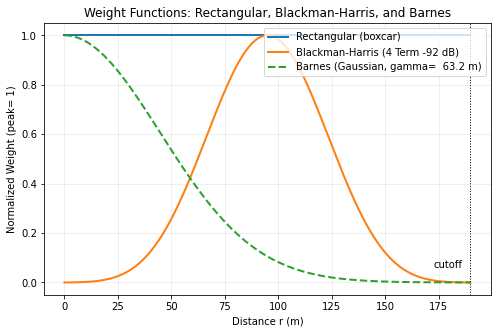

In [12]:
print("a) Rect Function for use with oban")
try:
    cutoff_radius= float(search_radius)
except NameError:
    try:
        cutoff_radius= 3.0 * float(data_spacing)
    except NameError:
        cutoff_radius= 3.0 * float(max_adjacent_spacing_m)

# smoothing parameter used earlier for Barnes (for comparison plotting)
try:
    gamma_meters= float(gamma)
except NameError:
    gamma_meters= float(data_spacing)  # fallback

print(f"Plotting weights from r=0 to cutoff_radius= {cutoff_radius:.1f} m. (gamma = {gamma_meters:.1f} m)")

# rectangular window
def rect(r, R):
    """
    Rectangular (boxcar) window in distance:
      r: array-like distances (meters)
      R: cutoff radius (meters)
    returns: weights (same shape as r), value 1 for r<=R, 0 otherwise
    """
    r = np.asarray(r)
    w = np.where(r<= R, 1.0, 0.0)
    return w

print("b) Blackman Harris Function")        # coeffs for -92 dB (Harris 1978)
_a0= 0.35875
_a1= 0.48829
_a2= 0.14128
_a3= 0.01168

def blackman_harris(r, R):
    """
    r: distances (meters)
    R: cutoff radius (meters)
    Equ: w(r)= a0-a1*cos(2*pi*r/R) + (a2*cos(4*pi*r/R)- a3*cos(6*pi*r/R)
    """
    r = np.asarray(r)
    w = np.zeros_like(r, dtype= float)
    inside= (r<= R) & (r>= 0)
    if np.any(inside):
        x= r[inside]/R                   # normalized
        w_in= (_a0-_a1*np.cos(2.0*np.pi*x)+_a2*np.cos(4.0*np.pi*x)- _a3*np.cos(6.0*np.pi*x))
        w_in= np.maximum(w_in, 0.0)      # ensuring non-neg
        w[inside]= w_in
    return w

# Barnes weight
def barnes_weight_r(r, gamma):
    r= np.asarray(r)
    return np.exp(-(r**2)/(gamma**2))

# r vector and weights
r= np.linspace(0.0, cutoff_radius, 501)
w_rect= rect(r, cutoff_radius)
w_bh= blackman_harris(r, cutoff_radius)
w_barnes= barnes_weight_r(r, gamma_meters)

# Normalizing windows
w_rect_n= w_rect/np.max(w_rect) if np.max(w_rect) != 0 else w_rect
w_bh_n= w_bh/np.max(w_bh) if np.max(w_bh) != 0 else w_bh
w_barnes_n= w_barnes/np.max(w_barnes) if np.max(w_barnes) != 0 else w_barnes

print("c) LaTeX derivation below")

print("d) Plot")
fig, ax= plt.subplots(1, 1, figsize= (8, 5))
ax.plot(r, w_rect_n, label= 'Rectangular (boxcar)', linewidth= 2)
ax.plot(r, w_bh_n, label= 'Blackman-Harris (4 Term -92 dB)', linewidth= 2)
ax.plot(r, w_barnes_n, label= f'Barnes (Gaussian, gamma= {gamma_meters: .1f} m)', linestyle= '--', linewidth= 2)
ax.set_xlabel('Distance r (m)')
ax.set_ylabel('Normalized Weight (peak= 1)')
ax.set_title('Weight Functions: Rectangular, Blackman-Harris, and Barnes')
ax.legend(loc= 'upper right')
ax.grid(alpha= 0.25)

# Cutoff
ax.axvline(cutoff_radius, color= 'k', linestyle= ':', linewidth= 1)
ax.text(0.98*cutoff_radius, 0.05, 'cutoff', ha= 'right', va= 'bottom', fontsize= 10)

plt.show()

Blackman-Harris window:

$ \[
w[n] = a_0-a_1\cos\left(\frac{2\pi n}{N-1}\right)
       + a_2\cos\left(\frac{4\pi n}{N-1}\right)
       - a_3\cos\left(\frac{6\pi n}{N-1}\right).
$\]

<span class="ecb">B-H should be centered on r=0. -2. Derivation details? -4</span>

**5.** Run the analysis with the two windows you defined in **4.** and plot them alongside the original data. (20 pts)

Running oban with Rectangular window (cutoff=189.7 m)...
Done. Finite cells: 10201 / 10201
Running oban with Blackman-Harris window (cutoff=189.7 m)...
Blackman–Harris: finite cells: 10201 / 10201


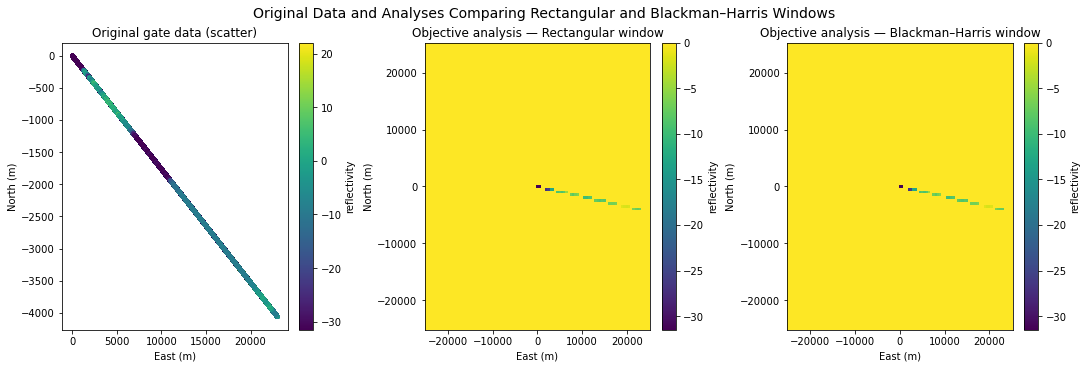

In [13]:
# prerequisites
for name in ['points', 'values', 'Xg', 'Yg', 'oban']:
    if name not in globals():
        raise RuntimeError(f"Required variable '{name}' is missing from the workspace. Run setup cells first.")
        
# setting cutoff radius
try: 
    cutoff_R= float(search_radius)
except NameError: 
    try: 
        cutoff_R= 3.0*float(data_spacing)
    except NameError: 
        cutoff_R= 3.0*float(max_adjacent_spacing_m)
        
# Restating weight functs and B-H coeffs 
def rect(r, R):
    r = np.asarray(r)
    return np.where((r >= 0) & (r <= R), 1.0, 0.0)

_a0 = 0.35875       # -92 dB
_a1 = 0.48829
_a2 = 0.14128
_a3 = 0.01168

def blackman_harris(r, R): 
    r= np.asarray(r)
    w= np.zeros_like(r, dtype= float)
    inside= (r>= 0) & (r<= R)
    if np.any(inside): 
        x= r[inside]/R
        w_in= (_a0-_a1*np.cos(2.0*np.pi*x)+_a2*np.cos(4.0*np.pi*x)- _a3*np.cos(6.0*np.pi*x))
        w_in= np.maximum(w_in, 0.0)
        w[inside]= w_in
    return w

# creating partials with cutoff
rect_func= partial(rect, R= cutoff_R)
bh_func= partial(blackman_harris, R= cutoff_R)

# flattening xi
xi= np.column_stack((Xg.ravel(), Yg.ravel()))
    
# Running the analyses
print(f"Running oban with Rectangular window (cutoff={cutoff_R:.1f} m)...")
analysis_rect_flat = oban(points, values, xi, rect_func, cutoff_R).reshape(Xg.shape)
analysis_rect = analysis_rect_flat.reshape(Xg.shape)
print("Done. Finite cells:", np.isfinite(analysis_rect).sum(), "/", analysis_rect.size)

print(f"Running oban with Blackman-Harris window (cutoff={cutoff_R:.1f} m)...")
analysis_bh_flat = oban(points, values, xi, bh_func, cutoff_R).reshape(Xg.shape)
analysis_bh = analysis_bh_flat.reshape(Xg.shape)
print("Blackman–Harris: finite cells:", np.isfinite(analysis_bh).sum(), "/", analysis_bh.size)

# Plots of original and analyses
fig, axs= plt.subplots(1, 3, figsize= (15, 5), constrained_layout= True)
ax0, ax1, ax2= axs
    
# Original
sc= ax0.scatter(points[:,0], points[:,1], c=values, s=12, cmap='viridis')
ax0.set_title('Original gate data (scatter)')
ax0.set_xlabel('East (m)'); ax0.set_ylabel('North (m)')
plt.colorbar(sc, ax= ax0, label= field_name)

# Rect
pcm1= ax1.pcolormesh(Xg, Yg, analysis_rect, shading='auto', cmap='viridis')
ax1.set_title('Objective analysis — Rectangular window')
ax1.set_xlabel('East (m)'); ax1.set_ylabel('North (m)')
plt.colorbar(pcm1, ax= ax1, label=field_name)

# BH
pcm2= ax2.pcolormesh(Xg, Yg, analysis_bh, shading='auto', cmap='viridis')
ax2.set_title('Objective analysis — Blackman–Harris window')
ax2.set_xlabel('East (m)'); ax2.set_ylabel('North (m)')
plt.colorbar(pcm2, ax= ax2, label= field_name)

plt.suptitle('Original Data and Analyses Comparing Rectangular and Blackman–Harris Windows', fontsize= 14)
plt.show()

**6.** Let's compare the different filters.

**a.** Plot the original data, and using the Barnes filter you defined as a common point of comparison, plot the difference with the other two analyses you calculated, (Barnes - other). (20 pts)

**b.** Which weighting scheme preserves the greatest detail in fine-scale structure? Illustrate this by discussing a local minimum and a local maximum in the original data vs. the difference fields. Does it make sense in terms of the theoretical response functions we calcualted in the previous homework? (5 pts)

a) Plotting Original Data


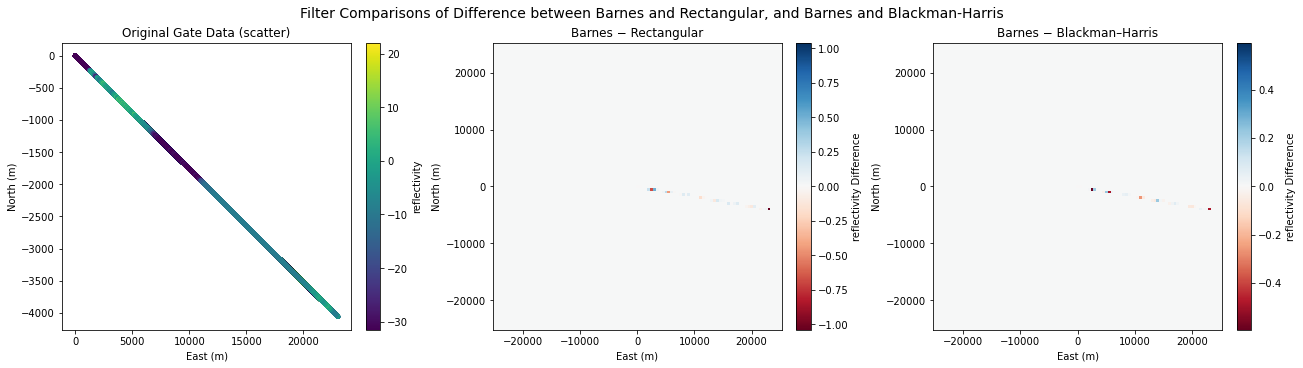

b) Which weighting scheme preserves the greatest detail in fine-scale structure? Find local max/min


In [ ]:
print("a) Plotting Original Data")

# Quick check
required = ['points', 'values', 'Xg', 'Yg', 'oban']
missing = [v for v in required if v not in globals()]
if missing:
    raise RuntimeError(f"Missing prerequisites: {missing}. Run setup and oban cells first.")

# Ensuring analysis_oban exists
if 'analysis_oban' not in globals():
    print("Recomputing analysis_oban (Barnes) with current my_barnes and search_radius...")
    try:
        xi= np.column_stack((Xg.ravel(), Yg.ravel()))
        analysis_oban= oban(points, values, xi, my_barnes, search_radius).reshape(Xg.shape)
        print("Recomputed analysis_oban:", analysis_oban.shape)
    except Exception as e:
        raise RuntimeError("Cannot compute analysis_oban: " + repr(e))
        
# Ensuring analysis_rect and analysis_bh exist
if 'analysis_rect' not in globals() or 'analysis_bh' not in globals():
    print("One of analysis_rect or analysis_bh not found — recomputing them using cutoff_R = search_radius.")
    
    def rect(r, R):
        r = np.asarray(r)
        return np.where((r >= 0) & (r <= R), 1.0, 0.0)
    _a0, _a1, _a2, _a3 = 0.35875, 0.48829, 0.14128, 0.01168
    
    def blackman_harris(r, R):
        r = np.asarray(r)
        w = np.zeros_like(r, dtype=float)
        inside = (r >= 0) & (r <= R)
        if np.any(inside):
            x = r[inside] / R
            w_in = (_a0 - _a1 * np.cos(2*np.pi*x) + _a2*np.cos(4*np.pi*x) - _a3*np.cos(6*np.pi*x))
            w_in = np.maximum(w_in, 0.0)
            w[inside] = w_in
        return w
    
    cutoff_R = float(search_radius) if 'search_radius' in globals() else 3.0 * float(data_spacing)
    rect_func = partial(rect, R=cutoff_R)
    bh_func   = partial(blackman_harris, R=cutoff_R)
    xi = np.column_stack((Xg.ravel(), Yg.ravel()))
    analysis_rect = oban(points, values, xi, rect_func, cutoff_R).reshape(Xg.shape)
    analysis_bh   = oban(points, values, xi, bh_func, cutoff_R).reshape(Xg.shape)
    print("Recomputed analysis_rect and analysis_bh")
    
# difference fields
diff_barnes_rect= analysis_oban-analysis_rect
diff_barnes_bh= analysis_oban-analysis_bh

# Plotting data and 2 maps
fig, axs = plt.subplots(1, 3, figsize=(18,5), constrained_layout=True)
ax0, ax1, ax2 = axs

# Original
sc = ax0.scatter(points[:,0], points[:,1], c=values, s=12, cmap='viridis')
ax0.set_title('Original Gate Data (scatter)')
ax0.set_xlabel('East (m)'); ax0.set_ylabel('North (m)')
plt.colorbar(sc, ax= ax0, label= field_name)

# Barnes-Rect
vmax1 = np.nanmax(np.abs(diff_barnes_rect))
pcm1 = ax1.pcolormesh(Xg, Yg, diff_barnes_rect, shading= 'auto', cmap= 'RdBu', vmin= -vmax1, vmax= vmax1)
ax1.set_title('Barnes − Rectangular')
ax1.set_xlabel('East (m)'); ax1.set_ylabel('North (m)')
plt.colorbar(pcm1, ax=ax1, label=f'{field_name} Difference')

# Barnes-BH
vmax2 = np.nanmax(np.abs(diff_barnes_bh))
pcm2 = ax2.pcolormesh(Xg, Yg, diff_barnes_bh, shading= 'auto', cmap= 'RdBu', vmin= -vmax2, vmax= vmax2)
ax2.set_title('Barnes − Blackman–Harris')
ax2.set_xlabel('East (m)'); ax2.set_ylabel('North (m)')
plt.colorbar(pcm2, ax= ax2, label= f'{field_name} Difference')

plt.suptitle('Filter Comparisons of Difference between Barnes and Rectangular, and Barnes and Blackman-Harris', fontsize= 14)
plt.show()



print("b) Which weighting scheme preserves the greatest detail in fine-scale structure? Find local max/min")

typical_spacing = float(data_spacing) if 'data_spacing' in globals() else float(max_adjacent_spacing_m)
nbr_radius = 1.5 * typical_spacing

tree_gates = cKDTree(points)   # points are (N,2)
Npts = points.shape[0]

# find points that are local minima or maxima compared to neighbors
local_mins = []
local_maxs = []
for i in range(Npts):
    idxs = tree_gates.query_ball_point(points[i], nbr_radius)
    if len(idxs) < 3:
        continue
    vals = values[idxs]
    vi = values[i]
    if np.all(vi <= vals + 1e-8):   # allow tiny tie tolerance
        local_mins.append(i)
    if np.all(vi >= vals - 1e-8):
        local_maxs.append(i)

if not local_mins or not local_maxs:
    print("No robust local extrema found with radius =", nbr_radius, "; trying larger radius (2*spacing).")
    nbr_radius = 2.0 * typical_spacing
    local_mins = []
    local_maxs = []
    for i in range(Npts):
        idxs = tree_gates.query_ball_point(points[i], nbr_radius)
        if len(idxs) < 3:
            continue
        vals = values[idxs]
        vi = values[i]
        if np.all(vi <= vals + 1e-8):
            local_mins.append(i)
        if np.all(vi >= vals - 1e-8):
            local_maxs.append(i)

if not local_mins or not local_maxs:
    print("Still no local extrema; using global min/max of the gate dataset.")
    imin = int(np.nanargmin(values))
    imax = int(np.nanargmax(values))
else:
    # compute score = |v - mean(neighbors)|
    def pick_most_extreme(idxs_list):
        best_idx = idxs_list[0]
        best_score = -1.0
        for ii in idxs_list:
            idxs = tree_gates.query_ball_point(points[ii], nbr_radius)
            m = np.nanmean(values[idxs])
            score = abs(values[ii] - m)
            if score > best_score:
                best_score = score
                best_idx = ii
        return best_idx
    imin = pick_most_extreme(local_mins)
    imax = pick_most_extreme(local_maxs)

# locations and values
loc_min = points[imin]
val_min = values[imin]
loc_max = points[imax]
val_max = values[imax]
print("\nSelected extrema points (from original gates):")
print(f" Local MIN index {imin}: location (E,N) = ({loc_min[0]:.1f}, {loc_min[1]:.1f}), original value = {val_min:.3f}")
print(f" Local MAX index {imax}: location (E,N) = ({loc_max[0]:.1f}, {loc_max[1]:.1f}), original value = {val_max:.3f}")

# Finding nearest grid cell in analysis grid to each point and sample analysis values
grid_pts = np.column_stack((Xg.ravel(), Yg.ravel()))
tree_grid = cKDTree(grid_pts)
_, idx_grid_min = tree_grid.query(loc_min, k=1)
_, idx_grid_max = tree_grid.query(loc_max, k=1)
ij_min = np.unravel_index(idx_grid_min, Xg.shape)
ij_max = np.unravel_index(idx_grid_max, Xg.shape)

# sample Barnes, Rect, BH at those grid cells
barnes_min = float(analysis_oban[ij_min])
rect_min   = float(analysis_rect[ij_min])
bh_min     = float(analysis_bh[ij_min])
diff_min_rect = barnes_min - rect_min
diff_min_bh   = barnes_min - bh_min

barnes_max = float(analysis_oban[ij_max])
rect_max   = float(analysis_rect[ij_max])
bh_max     = float(analysis_bh[ij_max])
diff_max_rect = barnes_max - rect_max
diff_max_bh   = barnes_max - bh_max

print("\nAt local MIN (nearest analysis-grid cell):")
print(f" Barnes = {barnes_min:.3f}, Rect = {rect_min:.3f}, BH = {bh_min:.3f}")
print(f" Differences: Barnes-Rect = {diff_min_rect:.3f}, Barnes-BH = {diff_min_bh:.3f}")

print("\nAt local MAX (nearest analysis-grid cell):")
print(f" Barnes = {barnes_max:.3f}, Rect = {rect_max:.3f}, BH = {bh_max:.3f}")
print(f" Differences: Barnes-Rect = {diff_max_rect:.3f}, Barnes-BH = {diff_max_bh:.3f}")

# markings on the plots
ax0.plot(loc_min[0], loc_min[1], marker='v', markersize=10, color='white', markeredgecolor='k', label='local min')
ax0.plot(loc_max[0], loc_max[1], marker='^', markersize=10, color='white', markeredgecolor='k', label='local max')
ax0.legend(loc='upper right')

ax1.plot(loc_min[0], loc_min[1], marker='v', markersize=8, color='k')
ax1.plot(loc_max[0], loc_max[1], marker='^', markersize=8, color='k')
ax2.plot(loc_min[0], loc_min[1], marker='v', markersize=8, color='k')
ax2.plot(loc_max[0], loc_max[1], marker='^', markersize=8, color='k')

plt.show()

At the local max, the nearest analysis-grid cell shows us that all of the analyses are negative when the original was +9.0. Therefore, the grid cell is most likely dominated by the other values in the neighborhood. The difference between Barnes and Rect is a bit larger than Barnes and BH, which tells us the rectangular window leaves more fine-scale features and the Blackman-Harris is a bit smoother. At the local min, all of the analyses were 0. This could be from a coding error on my part, missing data points marked as 0, or due to the point falling outside of the min location. This seems to make sense due to the Rectangular preserving sharper features locally. Blackman-Harris smooths much more from removing sidelobes, while the Barnes is a smooth low-pass.